In this notebook, we explore different boosting methods, namely XGBoost and CatBoost.
We also explore a bayesian optimization based python library called 'hyperOpt' for hyperparamter tuning.

Note that XGBoost and CatBoost training has been set to run on GPU to speed up training

In [ ]:
##Importing the required libraries

import numpy as np
import cupy
import pandas as pd
import time
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})

##Libraries for evaluation metrics and cross validation
from scipy.stats import entropy
from sklearn.model_selection import StratifiedGroupKFold

##bayesian optimization baased hyperOpt library
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval

##Libraries for ensemble methods considered in the study
from xgboost import XGBClassifier
import catboost

In [ ]:
# for reproducibility of K-fold dataset stratification and catboost model training
random_seed = 216 
# path to folder where train data after processing with merge_spectrogram_features_n_train_test_split.ipynb is stored
data_path = 'data/'

## Load data

Note that the training set being used is after feature selection (saved in feature_selection_catboost.ipynb)

In [ ]:
# reading the train set
train = pd.read_parquet(data_path + 'train_selected_features.parquet')

In [ ]:
train.shape

(29059, 2008)

In [ ]:
train.head()

,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,total_votes,...,eeg_max_f391_10s,RL_18.36_mean_10m,eeg_max_f496_10s,RL_8.2_mean_10m,eeg_std_f482_10s,eeg_std_f5_10s,eeg_min_f395_10s,RL_19.14_max_10m,RL_16.6_max_10m,LL_11.91_max_10m
0,1825637311,20654,Other,0.0,0.0,0.25,0.0,0.166667,0.583333,48,...,0.915917,1.997300,0.321155,14.899199,0.178087,0.099682,0.352378,213.360001,283.549988,147.690002
1,3254468733,5955,Other,0.0,0.0,0.00,0.0,0.000000,1.000000,1,...,0.838847,0.075333,0.029258,0.494100,0.093478,0.125884,0.399454,1.740000,1.140000,1.030000
2,2552357208,5955,Other,0.0,0.0,0.00,0.0,0.000000,1.000000,1,...,0.857768,0.076533,0.027460,0.482100,0.084322,0.100192,0.265065,1.740000,1.140000,1.030000
3,2898467035,38549,GPD,0.0,0.0,1.00,0.0,0.000000,0.000000,1,...,0.886398,0.104400,0.252423,2.158333,0.134317,0.140510,0.289365,0.390000,0.890000,3.400000
4,3255875127,40955,Other,0.0,0.0,0.00,0.0,0.000000,1.000000,2,...,0.577442,0.220367,-0.128264,1.586300,0.073278,0.056153,0.271641,1.630000,2.120000,1.450000


In [ ]:
# Vote columns corresponding to each of the classes
vote_cols = train.columns[train.columns.str.endswith('_vote')].tolist()
vote_cols

['seizure_vote',
 'lpd_vote',
 'gpd_vote',
 'lrda_vote',
 'grda_vote',
 'other_vote']

In [ ]:
# Features to be used for training
FEATURES = train.columns[range(10,train.shape[1])].tolist()
len(FEATURES)

1998

In [ ]:
# sample weights based on total votes
weights_total_vote = [min(t/3,1) for t in train.total_votes.tolist()]
weights_total_vote = np.array(weights_total_vote)
weights_total_vote.shape

(29059,)

## Helper functions

In [ ]:
## Function for evaluating the performance of model based on k-fold validation
def eval_kl_div(y_true, y_pred, sample_weight):
    """
    Parameters
    ----------
    y_true : 2D numpy array, True probability values
    y_pred : 2D numpy array, Predicted probability values
    sample_weight: numpy vector, for weighted average KL divergence

    Output
    ------
    Mean (averaged over all samples) KL divergence
    """

    # Compute KL divergence for all the samples
    kl_div_all = entropy(y_true, y_pred, axis=1)

    return np.average(kl_div_all, weights=sample_weight)

In [ ]:
def cross_validation(params, model, train, features, classes, weights, cv = 5, random_seed = 216):
  """
    Input:
    params - parameters for defining the classifier
    model - which model to use 'catboost' or 'xgboost'
    train - Dataset to perform K-fold CV and compute feature importance
    features - name of the features
    classes - labels for the eeg classification
    weights - for weighting of sample importance based on total votes
    cv - number of folds to be used in CV
    random_seed - set random number for reproducibility
    
    Output:
    Float: average KL divergence across k fold CV   
    """
  
  # for storing kl divergence in each of the CV folds
  all_val_kl_div = []

  # StratifiedGroupKFold in order to stratify on the expert consensus and separate patient IDs between k folds
  sgkf = StratifiedGroupKFold(n_splits=cv, shuffle=True, random_state=random_seed)
  for i, (train_index, valid_index) in enumerate(sgkf.split(X = train, y = train.expert_consensus, groups = train.patient_id)):

    # define the training set for the ith fold
    X_train = train.loc[train_index,features].values
    y_train = train.loc[train_index,classes].values

    # Adapted from https://stackoverflow.com/questions/75762712/how-to-train-xgboost-with-probabilities-instead-of-class
    # to train using the probability values of each class in the objective function instead of expert_consensus
    n_samples, n_classes = y_train.shape
    X_train_upsampled = X_train.repeat(n_classes, axis=0)
    y_train_direct = np.tile(range(n_classes), n_samples)
    sample_weights = (y_train * np.repeat(weights[train_index],6).reshape(len(weights[train_index]),6)).ravel()

    if model == 'xgb':
      # Define XGBoost classifier
      clf = XGBClassifier(objective='multi:softprob',
                          device = 'gpu',
                          num_class = len(classes),
                          tree_method = 'hist',
                          random_state=random_seed,
                          **params)
    elif model == 'catboost':
      # Define Catboost classifier
      clf = catboost.CatBoostClassifier(task_type='GPU',
                                        objective='MultiClass',
                                        random_state=random_seed,
                                        verbose=False,
                                        **params)

    ##fit the model
    clf.fit(X_train_upsampled, y_train_direct, sample_weight=sample_weights)

    # define the validation set for the ith fold
    X_val = train.loc[valid_index,FEATURES].values
    y_val = train.loc[valid_index,vote_cols].values

    # predict for validation set
    if model == 'xgb':
      y_pred = clf.predict_proba(cupy.asarray(X_val))
    elif model == 'catboost':
      y_pred = clf.predict_proba(X_val)
    # changing zeros in y_pred to 1e-15 to avoid inf from log
    y_pred = y_pred.clip(1e-15)

    # KL divergence for validation set
    all_val_kl_div.append(eval_kl_div(y_val, y_pred, weights[valid_index]))

    del X_train, y_train, X_train_upsampled, y_train_direct, X_val, y_val, y_pred, clf

  return np.asarray(all_val_kl_div).mean()


Using Bayesian optimization based hyperopt python library for finding the optimal hyperparameter set.



In [ ]:
##Code for using hyperopt for hysperparameter search to optimize F1 score is taken from
##https://www.kaggle.com/rendyk/bayesian-optimization-bayes-opt-or-fmin#hyperopt
##https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt

##Function to compute the optimal hyperparamter values using hyperOpt
def opt_hyperparameter(parameter_space,func_model,max_iterations):
    """
    Parameters
    ----------
    parameter_space : dict
        parameter space to be explored for optimizing F1 score where each key refers to a hyperparamter
        and that key's corresponding value defines the space to be explored for that hyperparamter
    func_model : value-returning function
        To be minimized by hyperopt.fmin(). In our case, since we want to minimize kl_div, func_model returns
        as mean kl_div from 5-fold cross validation
    max_iterations : Int
        maximum number of evaluations the fmin function will perform

    Output
    ------
    best: dict
        Optimal hyperparameter values obtained from fmin
    trials: object of type hyperopt.base.Trials
        Contains various outputs/characteristics after each evaluation, can be used to analysis
        the optimization history
    """

    trials = Trials()
    best = fmin(fn = func_model, space = parameter_space, algo=tpe.suggest, max_evals=max_iterations, trials=trials)

    return best, trials

##================================
##Function for plotting optimization history (F1-score vs iteration number)
##Taken from https://www.kaggle.com/fanvacoolt/tutorial-on-hyperopt
def optimization_history(trials):
    """
    Parameters
    ----------
    trials: object of type hyperopt.base.Trials
        Contains various outputs/characteristics after each evaluation, can be used to analysis
        the optimization history
    """

    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(trials) + 1), [x['result']['loss'] for x in trials],
            color='red', marker='.', linewidth=0)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('KL Divergence', fontsize=12)
    plt.title('Optimization history', fontsize=14)
    plt.grid(True)

XGBosst with default parameters

In [ ]:
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_seed)

for i, (train_index, valid_index) in enumerate(sgkf.split(X = train, y = train.expert_consensus, groups = train.patient_id)):
  t = time.time()
  print('#'*25)
  print(f'### Fold {i+1}')
  print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
  print('#'*25)
  break

#########################
### Fold 1
### train size 23659, valid size 5400
#########################


In [ ]:
X_train = train.loc[train_index,FEATURES].values
y_train = train.loc[train_index,vote_cols].values #.map(TARGETS)

In [ ]:
##Adapted from https://stackoverflow.com/questions/75762712/how-to-train-xgboost-with-probabilities-instead-of-class
n_samples, n_classes = y_train.shape
X_train_upsampled = X_train.repeat(n_classes, axis=0)
y_train_direct = np.tile(range(n_classes), n_samples)
sample_weights = (y_train * np.repeat(weights_total_vote[train_index],6).reshape(len(weights_total_vote[train_index]),6)).ravel()

In [ ]:
##define model
clf_xgb = XGBClassifier(objective='multi:softprob',
                        device = 'gpu',
                        num_class = len(vote_cols),
                        tree_method = 'hist',
                        random_state=random_seed)

t = time.time()
#fit the model
clf_xgb.fit(X_train_upsampled, y_train_direct, verbose=True, sample_weight=sample_weights)

print(time.time() - t)

53.48831081390381


In [ ]:
X_val = train.loc[valid_index,FEATURES].values
y_val = train.loc[valid_index,vote_cols].values

##predict for validation set
y_pred = clf_xgb.predict_proba(cupy.asarray(X_val))
##changing zeros in y_pred to 1e-15 to avoid inf from log
y_pred = y_pred.clip(1e-15)

##KL divergence for validation set
eval_kl_div(y_val, y_pred, weights_total_vote[valid_index])

0.8316445963134554

In [ ]:
del clf_xgb, X_train, y_train, X_val, y_val, y_pred, X_train_upsampled, y_train_direct, sample_weights

## Hyperparameter tuning

### XGBoost

For hyperparameter tuning, we used bayesian optimization based hyperopt python library.

**Note:**

**1) Run time for the following hyperparamter search is ~3hrs using GPU-based training. Consider using the optimal hyperparameter pre-defined in the next cell that has been found after running this hyperparmameter search.** 

**2) Due to randomization in the hyperOpt based search, you might get different values for the hyperparamter if you run the hyperparameter search in the next cell. But the optimal mean KL divergence (average over k-fold CV) from the search would still be around 0.78 for XGBoost.**

{'colsample_bytree': 0.6977536424351765, 'gamma': 0.09363067619834166, 'learning_rate': 0.12018896425876123, 'max_depth': 6, 'n_estimators': 243, 'reg_lambda': 3.2637216152125434, 'subsample': 0.8708744732069559}
{'colsample_bytree': 0.7542804734126611, 'gamma': 0.13435343831313093, 'learning_rate': 0.3421327777694388, 'max_depth': 6, 'n_estimators': 392, 'reg_lambda': 3.5606567072880164, 'subsample': 0.9366898663486878}
{'colsample_bytree': 0.8465673239049628, 'gamma': 0.17781918881544873, 'learning_rate': 0.37988208457316275, 'max_depth': 6, 'n_estimators': 279, 'reg_lambda': 3.6321671957595085, 'subsample': 0.6321873543672205}
{'colsample_bytree': 0.6630250525159908, 'gamma': 0.07101103183218484, 'learning_rate': 0.14035431472384935, 'max_depth': 4, 'n_estimators': 417, 'reg_lambda': 1.448199041203513, 'subsample': 0.6758329544410134}
{'colsample_bytree': 0.6254559710125687, 'gamma': 0.17100714012204568, 'learning_rate': 0.368497966318927, 'max_depth': 2, 'n_estimators': 121, 'reg_l

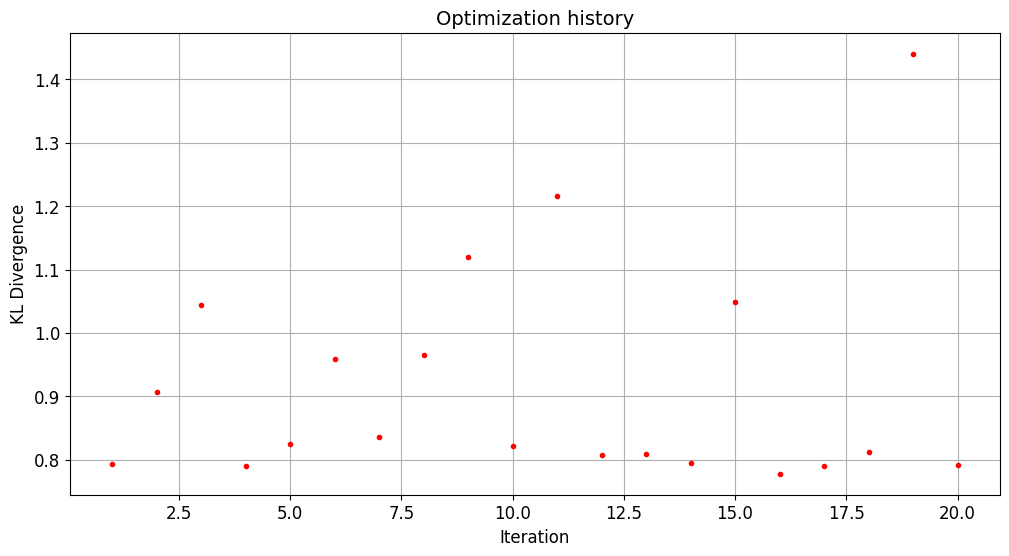

In [ ]:
##Code for using hyperopt for hysperparameter search to optimize KL divergence is taken from
##https://www.kaggle.com/rendyk/bayesian-optimization-bayes-opt-or-fmin#hyperopt
##https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt

##Define the hyperparamterparamter space
xgbc_param_space = {'max_depth': hp.choice('max_depth', range(2,9)),
 'learning_rate': hp.uniform('learning_rate',0.05,0.5),
 'subsample': hp.uniform('subsample',0.5,1.0),
 'n_estimators': hp.choice('n_estimators', range(100,500)),
 'reg_lambda': hp.uniform('reg_lambda',1,4),
 'gamma': hp.uniform('gamma',0,0.3),
 'colsample_bytree': hp.uniform('colsample_bytree',0.5,1.0)}

best = 0
##The function to be optimized by hyperopt.fmin(), i.e. output of this function is mean KL_div (averaged over k-fold CV)
##which is being optimized by hyprOpt.fmin().
def xgbc_func(params):
    global best
    print(params)

    ##Compute the mean KL div score for kfold cross validation
    score = cross_validation(params, 'xgb', train, FEATURES, vote_cols, weights_total_vote, 5, random_seed)

    ##For keeping track of optimal KL div, print the score everytime a better value is found
    if score < best:
        best = score
        print ('new best:', best)

    ##returning -ve of score because hyperopt.fmin() minimizes a function
    return {'loss': score, 'status': STATUS_OK}

##Start the timer for hyperparamter optimization
start = time.time()
##Max number of evaluations for hyperopt.fmin()
max_iterations = 20
##Find the optimal hyperparamter set. Also storing the optimization history
xgbc_param_space_indices, xgbc_trials = opt_hyperparameter(xgbc_param_space,xgbc_func,max_iterations)
##Obtain the hyperparamter values in the hyperparamter space defined by xgbc_param_space_indices
xgbc_best_hp = space_eval(xgbc_param_space,xgbc_param_space_indices)

print('It takes %s minutes' % ((time.time() - start)/60))
print('---------------Optimal Hyperparamter Set-------------------')
print(xgbc_best_hp)
print('---------------Optimization History-------------------')
optimization_history(xgbc_trials)

In [ ]:
#xgbc_best_hp = {'colsample_bytree': 0.6376657493489575, 'gamma': 0.17012927852299328, 'learning_rate': 0.13440876516049854, 'max_depth': 3, 'n_estimators': 470, 'reg_lambda': 2.1752761618923397, 'subsample': 0.7988428380922181}

### Since XGBoost performance was found to be best among the models considered, we train the XGBoost model on all the train set and will use that for subsequent performance evaluation on the test set

In [ ]:
# Define the training set
X_train = train.loc[:,FEATURES].values
y_train = train.loc[:,vote_cols].values

# Adapted from https://stackoverflow.com/questions/75762712/how-to-train-xgboost-with-probabilities-instead-of-class
# to train using the probability values of each class in the objective function instead of expert_consensus
n_samples, n_classes = y_train.shape
X_train_upsampled = X_train.repeat(n_classes, axis=0)
y_train_direct = np.tile(range(n_classes), n_samples)
sample_weights = (y_train * np.repeat(weights_total_vote,6).reshape(len(weights_total_vote),6)).ravel()

In [ ]:
# Optimal parameters from XGBoost from hyperopt search 
xgbc_best_hp = {'colsample_bytree': 0.6376657493489575, 'gamma': 0.17012927852299328, 'learning_rate': 0.13440876516049854, 'max_depth': 3, 'n_estimators': 470, 'reg_lambda': 2.1752761618923397, 'subsample': 0.7988428380922181}

##Define XGBoost classifier
clf_xgb = XGBClassifier(objective='multi:softprob',
                    device = 'gpu',
                    num_class = len(vote_cols),
                    tree_method = 'hist',
                    random_state=random_seed,
                    **xgbc_best_hp)

t = time.time()
#fit the model
clf_xgb.fit(X_train_upsampled, y_train_direct, verbose=True, sample_weight=sample_weights)
print(time.time() - t)


213.53096652030945


In [ ]:
##predict for validation set
y_pred = clf_xgb.predict_proba(cupy.asarray(X_train))
##changing zeros in y_pred to 1e-15 to avoid inf from log
y_pred = y_pred.clip(1e-15)

##KL divergence for validation set
eval_kl_div(y_train, y_pred, weights_total_vote)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:59:00] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


0.2865178577432836

In [ ]:
# Save the XGBoost model
clf_xgb.save_model(data_path + 'xgb_model.json')

### Catboost

For hyperparameter tuning, we used bayesian optimization based hyperopt python library.

**Note:**

**1) Run time for the following hyperparamter search is ~3hrs using GPU-based training. Consider using the optimal hyperparameter pre-defined in the next cell that has been found after running this hyperparmameter search.** 

**2) Due to randomization in the hyperOpt based search, you might get different values for the hyperparamter if you run the hyperparameter search in the next cell. But the optimal mean KL divergence (average over k-fold CV) from the search would still be around 0.79 for CatBoost.**

{'bagging_temperature': 6.350565850483695, 'learning_rate': 0.119784975895943, 'max_depth': 6, 'n_estimators': 404, 'reg_lambda': 1.690814335164336}
{'bagging_temperature': 2.1512882579942225, 'learning_rate': 0.49555186163361264, 'max_depth': 6, 'n_estimators': 270, 'reg_lambda': 1.8852796346263765}
{'bagging_temperature': 1.2232856605018305, 'learning_rate': 0.4364773675660722, 'max_depth': 3, 'n_estimators': 177, 'reg_lambda': 3.1405018134697382}
{'bagging_temperature': 9.55908629063151, 'learning_rate': 0.20369630375928732, 'max_depth': 3, 'n_estimators': 429, 'reg_lambda': 1.5705292381315563}
{'bagging_temperature': 9.520115614164405, 'learning_rate': 0.09517981929194785, 'max_depth': 4, 'n_estimators': 202, 'reg_lambda': 2.411498140102595}
{'bagging_temperature': 4.42129594150243, 'learning_rate': 0.12307438577577719, 'max_depth': 6, 'n_estimators': 195, 'reg_lambda': 1.2031929205566803}
{'bagging_temperature': 8.541210410355992, 'learning_rate': 0.20440392663892926, 'max_depth':

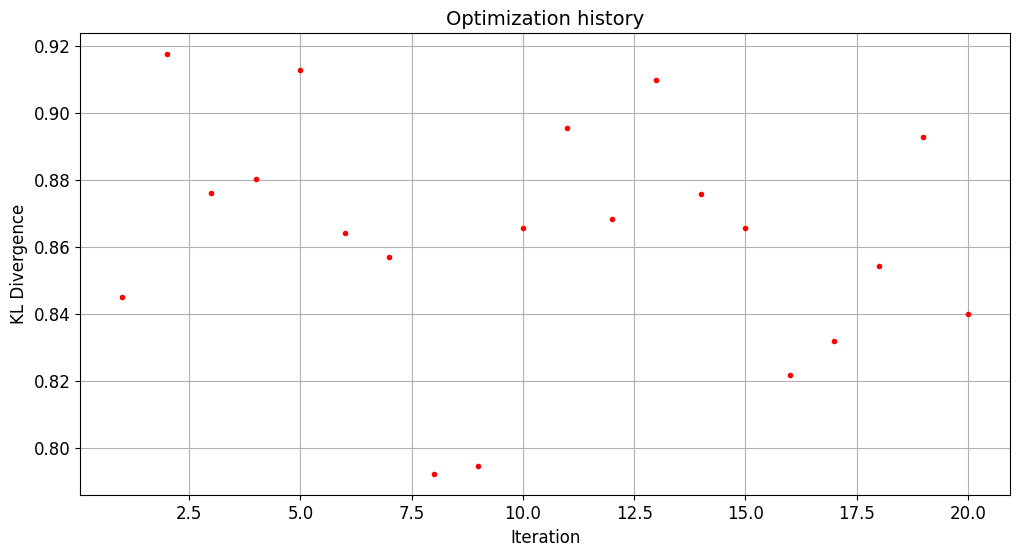

In [ ]:
##Code for using hyperopt for hysperparameter search to optimize KL divergence is taken from
##https://www.kaggle.com/rendyk/bayesian-optimization-bayes-opt-or-fmin#hyperopt
##https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt

## Define the hyperparamterparamter space
catb_param_space = {'max_depth': hp.choice('depth', range(3,9)),
                    'learning_rate': hp.uniform('learning_rate',0.05,0.5),
                    'n_estimators': hp.choice('n_estimators', range(100,500)),
                    'bagging_temperature': hp.uniform('bagging_temperature',0,10),
                    'reg_lambda': hp.uniform('reg_lambda',1,4)}

best = 0
##The function to be optimized by hyperopt.fmin(), i.e. output of this function is mean KL_div (averaged over k-fold CV)
##which is being optimized by hyprOpt.fmin().
def cat_func(params):
    global best
    print(params)

    ##Compute the mean KL div score for kfold cross validation
    score = cross_validation(params, 'catboost', train, FEATURES, vote_cols, weights_total_vote, 5, random_seed)

    ##For keeping track of optimal KL div, print the score everytime a better value is found
    if score < best:
        best = score
        print ('new best:', best)

    ##returning -ve of score because hyperopt.fmin() minimizes a function
    return {'loss': score, 'status': STATUS_OK}

##Start the timer for hyperparamter optimization
start = time.time()
##Max number of evaluations for hyperopt.fmin()
max_iterations = 20
##Find the optimal hyperparamter set. Also storing the optimization history
catb_param_space_indices, catb_trials = opt_hyperparameter(catb_param_space,cat_func,max_iterations)
##Obtain the hyperparamter values in the hyperparamter space defined by catb_param_space_indices
catb_best_hp = space_eval(catb_param_space,catb_param_space_indices)

print('It takes %s minutes' % ((time.time() - start)/60))
print('---------------Optimal Hyperparamter Set-------------------')
print(catb_best_hp)
print('---------------Optimization History-------------------')
optimization_history(catb_trials)

In [ ]:
# cat_best_hp = {'bagging_temperature': 0.7665886327736982, 'learning_rate': 0.1077957616344895, 'max_depth': 7, 'n_estimators': 345, 'reg_lambda': 1.6896137369937578}